In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
scaled_data = pd.read_csv("../data/processed/scaled_data.csv", index_col=0)
scaled_data.head()

,Open,High,Low,Close,MA20,MA50,Rolling_STD,Daily_Return,Volatility,Upper_Band,...,%B,RSI,Close_Open_Diff,High_Low_Diff,High_Volatility,Volatility_Price_Ratio,Momentum,Rolling_Return_5d,MA20_MA50_Interaction,Close_Volatility_Interaction
date,,,,,,,,,,,,,,,,,,,,,
2014-11-23,2.191889,2.257424,2.252358,2.192606,2.266625,1.613936,-0.412957,0.954561,2.01357,2.215342,...,-0.328197,0.488581,0.297949,-0.160033,2.810876,-0.556635,0.550805,1.092093,2.015158,2.658475
2014-11-24,2.308272,2.330381,2.312030,2.302185,2.266625,1.613936,-0.412957,0.954561,2.01357,2.215342,...,0.320088,0.488581,-1.410482,0.022916,2.810876,-0.563156,0.550805,1.092093,2.015158,2.689204
2014-11-25,2.389062,2.416758,2.384088,2.391431,2.266625,1.613936,-0.412957,0.775757,2.01357,2.215342,...,0.848072,0.488581,0.725057,0.219317,2.810876,-0.568423,0.550805,1.092093,2.015158,2.714231
2014-11-26,2.439155,2.409953,2.424995,2.439066,2.266625,1.613936,-0.412957,0.417363,2.01357,2.215342,...,1.129887,0.488581,0.108123,-0.464050,2.810876,-0.571217,0.550805,1.092093,2.015158,2.727590
2014-11-27,2.350267,2.350416,2.359130,2.356410,2.266625,1.613936,-0.412957,-0.694317,2.01357,2.215342,...,0.640888,0.488581,1.674186,-0.367195,2.810876,-0.566361,0.550805,1.092093,2.015158,2.704410


In [3]:
split_idx = int(len(scaled_data) * 0.75)

# Train-Test Split
X = scaled_data.drop(columns=['Close'])
y = scaled_data['Close']
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1956, 31)
(652, 31)
(1956,)
(652,)


# Build FULL Random Forrest model
Random Forrest model containing all 31 features. The goal is to examine feature importance and dominance

In [4]:
#fit model
rf_full = RandomForestRegressor(n_estimators=100, random_state=42)
rf_full.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [5]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_full.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                         Feature    Importance
0                           Open  9.959502e-01
2                            Low  3.981913e-03
1                           High  2.622794e-05
23               Close_Open_Diff  4.008632e-06
21                            %B  3.181642e-06
11                    Lag1_Close  2.963346e-06
30  Close_Volatility_Interaction  2.126306e-06
6                   Daily_Return  2.049293e-06
12                    Lag2_Close  1.995839e-06
17                   Daily_Range  1.918477e-06
18                  Weekly_Range  1.861832e-06
3                           MA20  1.859182e-06
4                           MA50  1.791699e-06
24                 High_Low_Diff  1.715601e-06
8                     Upper_Band  1.565329e-06
22                           RSI  1.547333e-06
7                     Volatility  1.421381e-06
29         MA20_MA50_Interaction  1.421295e-06
27                      Momentum  1.400813e-06
26        Volatility_Price_Ratio  1.380403e-06
10           

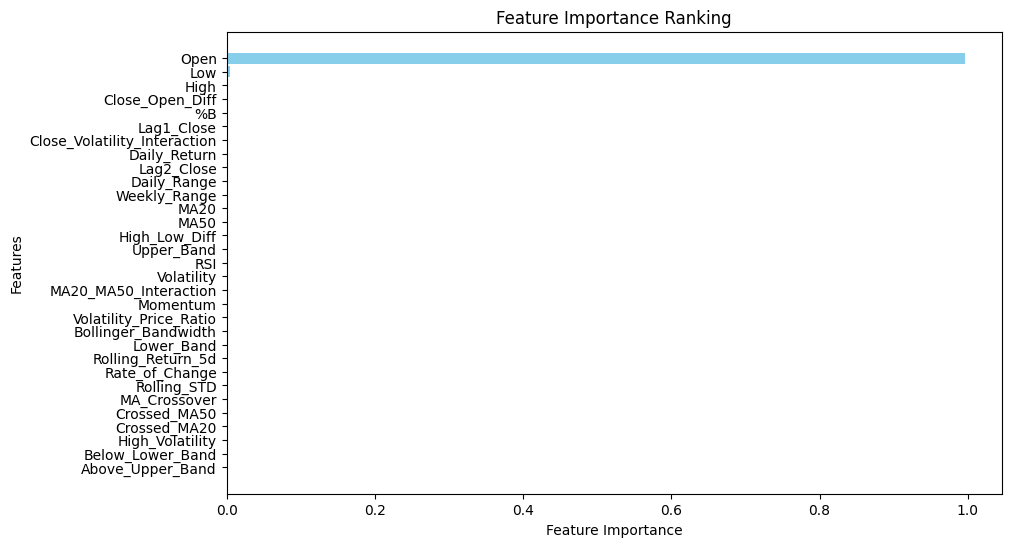

In [6]:
# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Ranking')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

In [7]:
#test model performance
pred = rf_full.predict(X_test)
print(f"R2 score: {r2_score(y_test, pred)}")
print(f"mse score: {mean_squared_error(y_test, pred)}")

R2 score: 0.7515292955049007
mse score: 0.09799710133621797


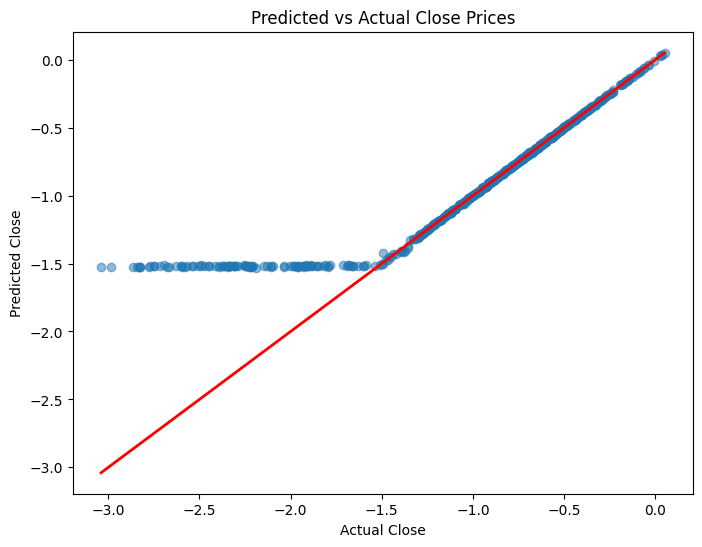

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel("Actual Close")
plt.ylabel("Predicted Close")
plt.title("Predicted vs Actual Close Prices")
plt.show()

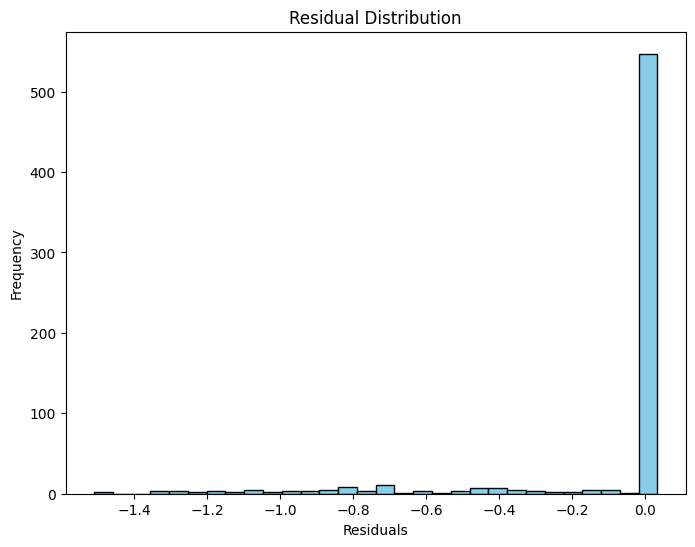

In [9]:
residuals = y_test - pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', color='skyblue')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

## Build RF model without 'open' feature
there might be over reliance on the `open` feature, we will remove it and test again

In [10]:
rf_N_open = RandomForestRegressor(n_estimators=100, random_state=42)
rf_N_open.fit(X_train.drop(columns=['Open']), y_train)

RandomForestRegressor(random_state=42)

In [11]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.drop(columns=['Open']).columns,
    'Importance': rf_N_open.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                         Feature  Importance
0                           High    0.678010
1                            Low    0.319120
10                    Lag1_Close    0.000751
11                    Lag2_Close    0.000236
5                   Daily_Return    0.000217
29  Close_Volatility_Interaction    0.000209
16                   Daily_Range    0.000129
23                 High_Low_Diff    0.000119
17                  Weekly_Range    0.000112
3                           MA50    0.000107
22               Close_Open_Diff    0.000104
8                     Lower_Band    0.000101
20                            %B    0.000093
7                     Upper_Band    0.000087
15                Rate_of_Change    0.000083
21                           RSI    0.000075
27             Rolling_Return_5d    0.000067
2                           MA20    0.000066
26                      Momentum    0.000064
28         MA20_MA50_Interaction    0.000050
6                     Volatility    0.000043
9         

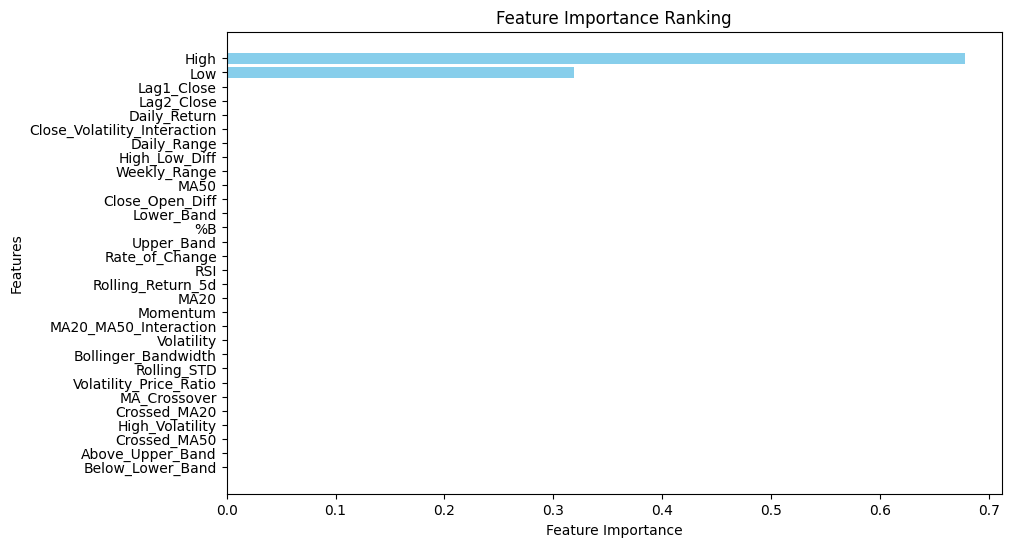

In [12]:
# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Ranking')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

In [13]:
#test model performance
pred = rf_full.predict(X_test)
print(f"R2 score: {r2_score(y_test, pred)}")
print(f"mse score: {mean_squared_error(y_test, pred)}")

R2 score: 0.7515292955049007
mse score: 0.09799710133621797


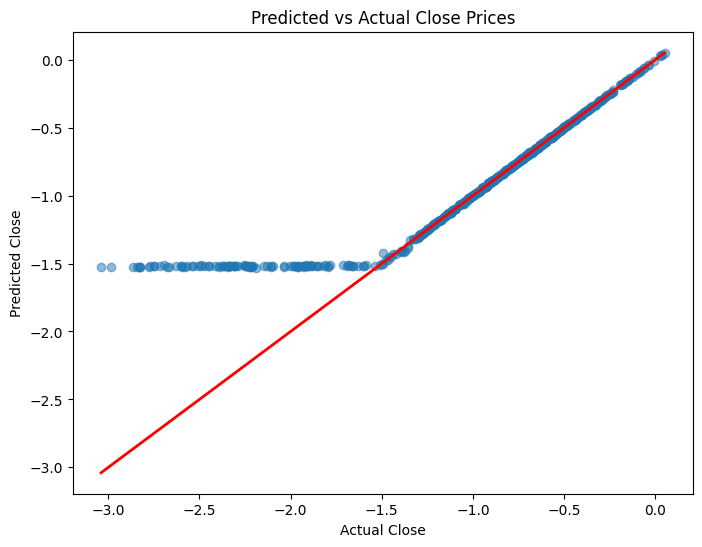

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel("Actual Close")
plt.ylabel("Predicted Close")
plt.title("Predicted vs Actual Close Prices")
plt.show()

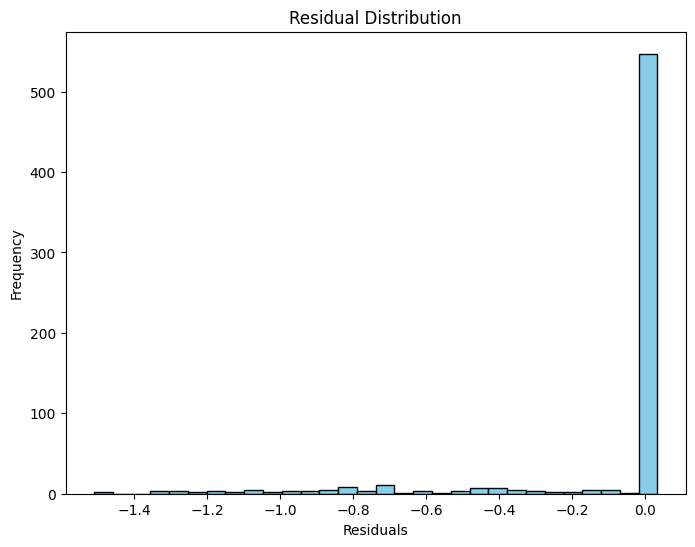

In [15]:
residuals = y_test - pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', color='skyblue')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()